In [1]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load model path into logic_ensemble object

In [2]:
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
model = le.LogicEnsemble(model_path, project_name = 'herault_hematopoiesis')
model.create_simulation()

Simulation object created


# Calculate attractors from the model cohorts
In this part of the script, we calculate attractors from cohorts of model, and compared using clustermap

In [ ]:
test = pd.read_csv(model_path + '/bn_0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))
test_dict

# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [3]:
traj_dir = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis' 
traj_data = pd.read_csv('/home/spankaew/Git/astrologics/models/herault_hematopoiesis_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['iHSC']
initial_state = initial_state.dropna().to_dict()

In [4]:
test = pd.read_csv(model_path + 'bn0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))
test_dict

{'Bclaf1': 0.5,
 'CDK46CycD': 0.5,
 'CIPKIP': 0.5,
 'Cebpa': 0.5,
 'Egr1': 0.5,
 'Fli1': 0.5,
 'Gata1': 0.5,
 'Gata2': 0.5,
 'Ikzf1': 0.5,
 'Junb': 0.5,
 'Klf1': 0.5,
 'Myc': 0.5,
 'Spi1': 0.5,
 'Tal1': 0.5,
 'Zfpm1': 0.5}

In [ ]:
model.simulation.update_parameters(max_time = 30,thread_count = 15, sample_count = 5000)
model.simulation.run_simulation(initial_state=test_dict)

Start simulation


100%|██████████| 616/616 [01:27<00:00,  7.03it/s]

Simulation completed


In [ ]:
model_path = '/home/spankaew/Git/astrologics/models/'
model.simulation.simulation_df = pd.read_csv(model_path + 'hh_simulation_df_random.csv', index_col = 0)

Trajectory object created


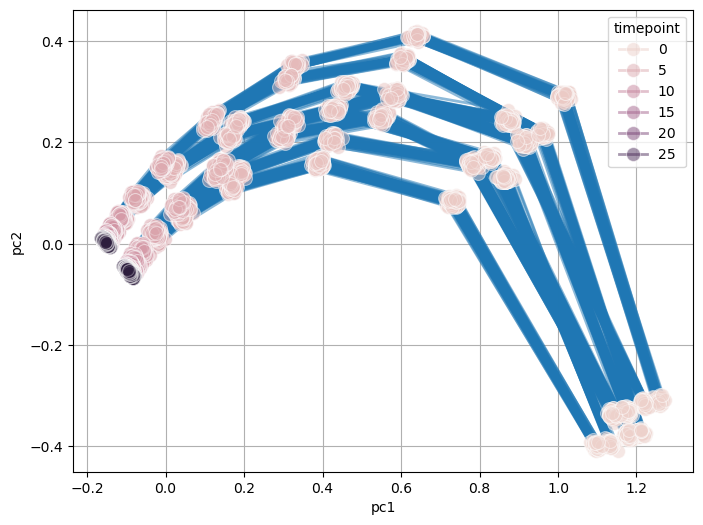

In [8]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

In [30]:
import pandas as pd

# Assuming `model_mtx` is your DataFrame with genes as columns and 'timepoint' as one of the columns
model_mtx = model.trajectory.simulation_df

# Group by 'timepoint' and calculate variance for each gene
variance_results = model_mtx.groupby('timepoint')[model_mtx.columns[:-3]].var()
variance_results['avg'] = variance_results.mean(axis = 1)

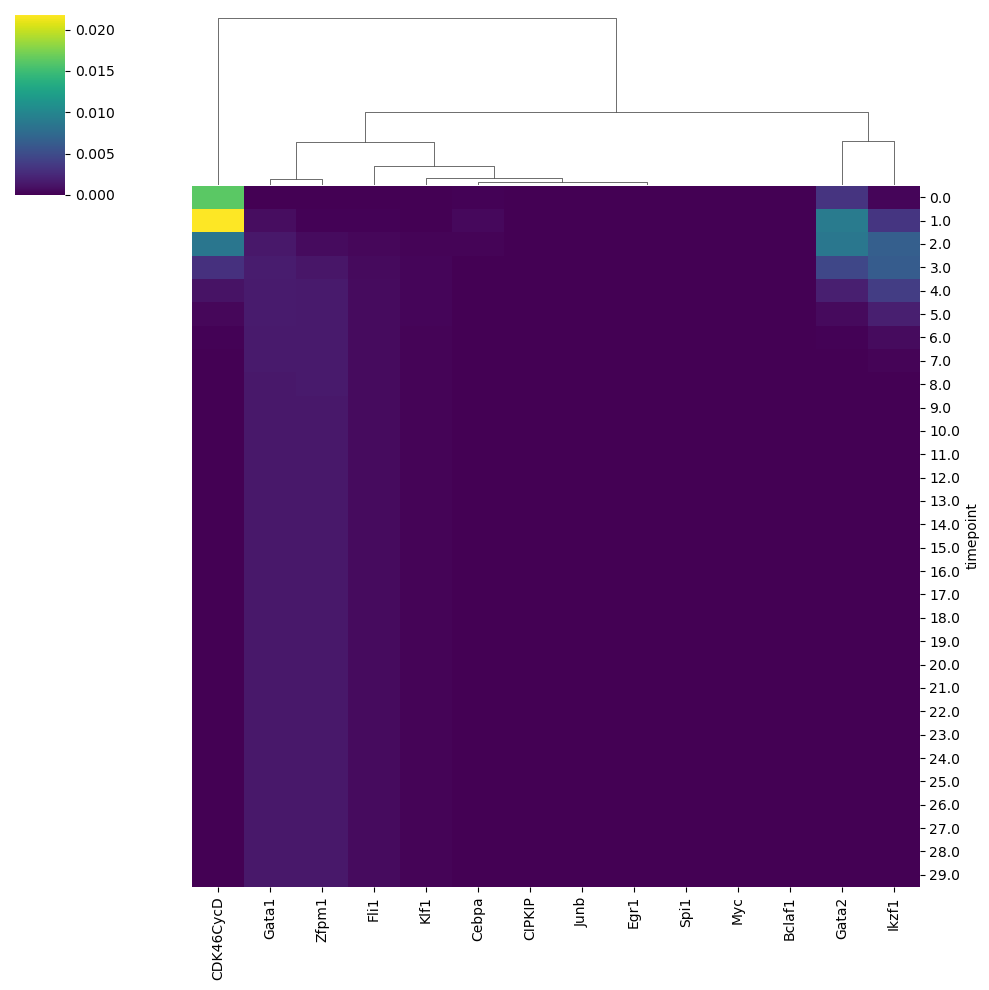

In [31]:
sns.clustermap(variance_results.drop(columns = ['avg']), row_cluster=False, cmap = 'viridis', figsize = (10,10))

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [9]:
import numpy as np
# Setup the 
pca_df = model.trajectory.pca_df
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

100%|██████████| 616/616 [00:23<00:00, 26.58it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hier

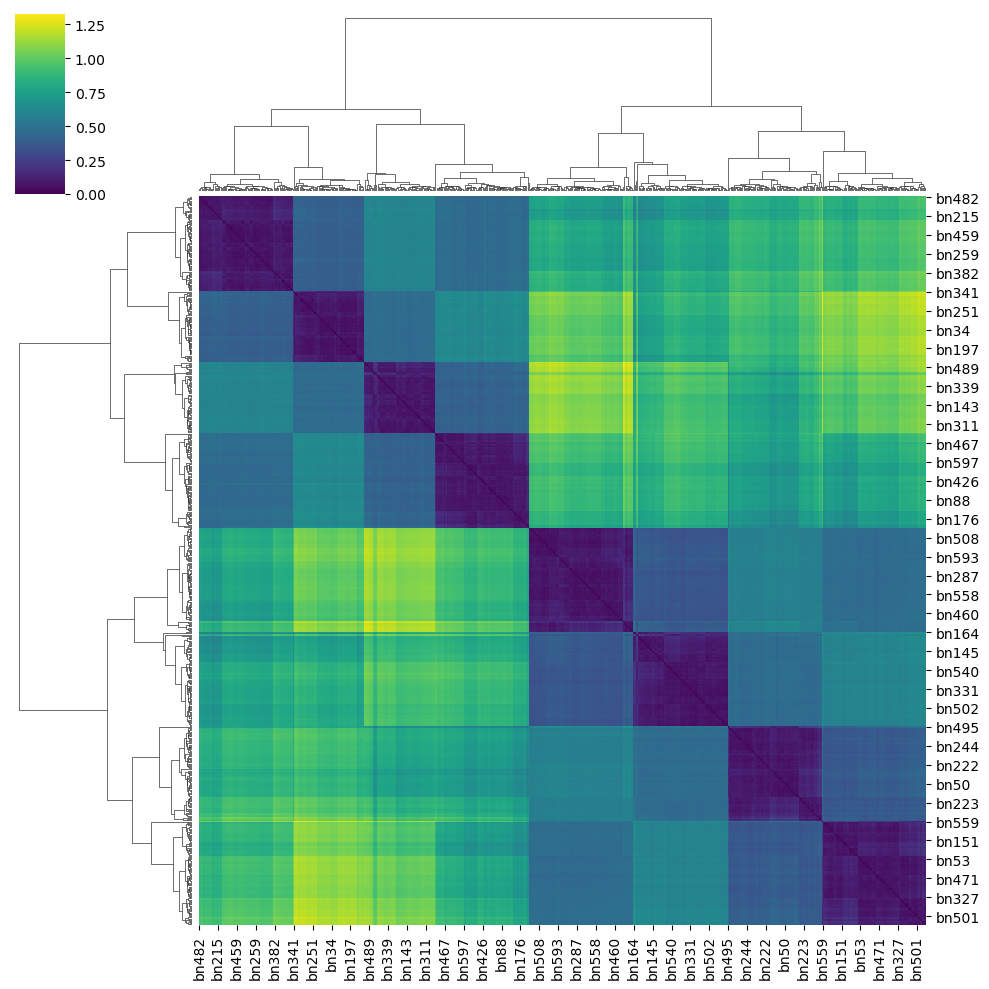

In [10]:
from tslearn.metrics import dtw
from tqdm import tqdm

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in tqdm(range(num_trajectories)):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_17820/2679887341.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


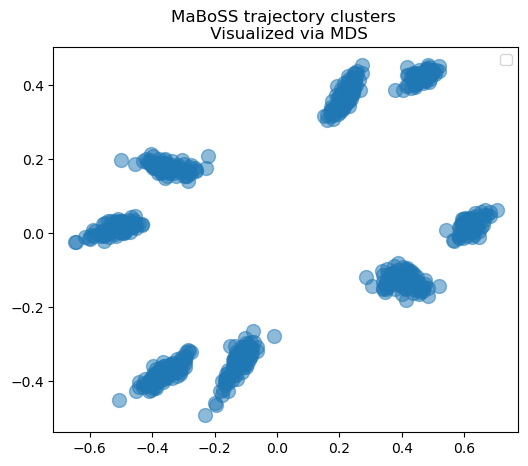

In [11]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_trajMDS_v3.pdf')

plt.show()

plt.close()

In [13]:
model.trajectory.calculate_kmean_cluster(n_cluster=8, data = 'original', metric = 'dtw')

cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, cluster_dict_df],axis = 1)

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.

0.009 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s


0.005 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s


0.005 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astr

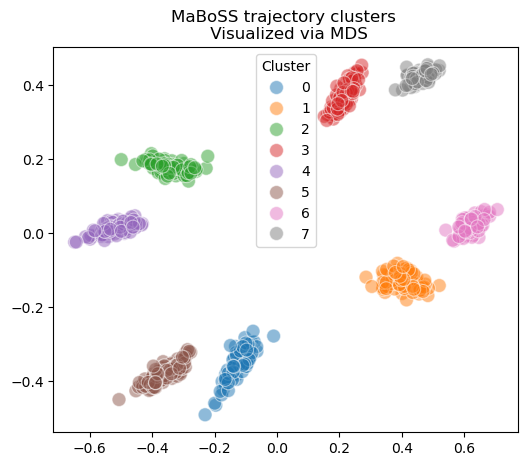

In [14]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='traj_cluster', palette='tab10', alpha=0.5, s=100)
plt.legend(title='Cluster')
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
plt.xlabel(None)
plt.ylabel(None)

#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_trajMDS_cluster.pdf')

plt.show()
plt.close()

Succession diagram object created
Calculating Succession Diagrams


100%|██████████| 616/616 [04:33<00:00,  2.25it/s]


Succession Diagrams calculated


100%|██████████| 616/616 [00:03<00:00, 178.48it/s]


Creating SD networks


100%|██████████| 616/616 [00:03<00:00, 203.11it/s]


SD networks created


  0%|          | 0/616 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
100%|██████████| 616/616 [09:06<00:00,  1.13it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better 

SD networks distance calculated


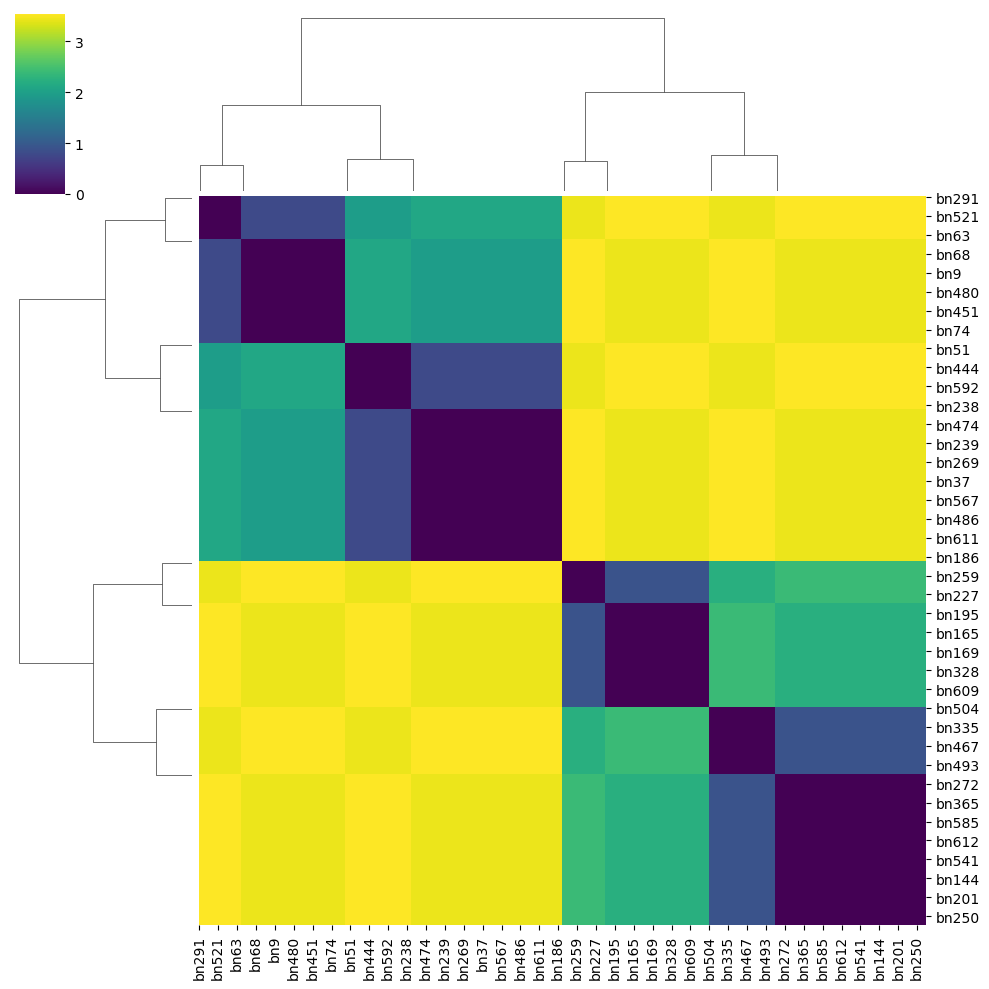

In [9]:
model.create_succession_diagram()
model.succession_diagram.calculate_succession_diagram()
model.succession_diagram.calculate_sd_states()
model.succession_diagram.create_sd_networks()
model.succession_diagram.calculate_sdnet_distance()
sns.clustermap(model.succession_diagram.distance_matrix, cmap='viridis')

In [10]:
sns.clustermap(model.succession_diagram.states_bin, figsize = (20,10))
plt.savefig('../hh_sd_states.pdf')
plt.close()

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/tmp/ipykernel_387938/1480729853.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


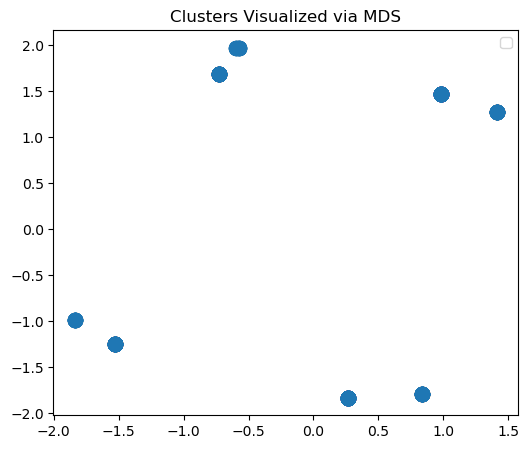

In [13]:
# Visualize clusters with MDS
distance_matrix_2 = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix_2)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('Clusters Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_sdMDS.pdf')

plt.show()

plt.close()

In [11]:
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape ,dtype = bool), k=1)).stack().reset_index()
distances_1['combined'] = distances_1['level_0'] + "_" + distances_1['level_1']
distances_1.set_index('combined', inplace=True)
distances_1.drop(columns=['level_0', 'level_1'], inplace=True)
distances_1.columns = ['traj_distance']

In [12]:
distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape ,dtype = bool), k=1)).stack().reset_index()
distances_2['combined'] = distances_2['level_0'] + "_" + distances_2['level_1']
distances_2.set_index('combined', inplace=True)
distances_2.drop(columns=['level_0', 'level_1'], inplace=True)
distances_2.columns = ['sd_distance']

NameError: name 'distance_matrix_2' is not defined

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Get traj cluster
model.trajectory.calculate_kmean_cluster(n_cluster=2, data = 'original', metric = 'euclidean')
cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

# Get sd cluster
model.succession_diagram.cluster_sdnet(n_cluster = 2)
sd_cluster = pd.DataFrame(model.succession_diagram.clusters, index = model.succession_diagram.distance_matrix.index, columns=['sd_cluster'])

# Combine the dataframes
cluster_dict_df = pd.concat([cluster_dict_df, sd_cluster], axis = 1, ignore_index = False)

# Calculate Rand Index
labels1 = cluster_dict_df['traj_cluster']  # from method 1
labels2 = cluster_dict_df['sd_cluster']  # from method 2

# Calculate the Adjusted Rand Index
ari_score = adjusted_rand_score(labels1, labels2)
print(f'Adjusted Rand Index: {ari_score}')

Euclidean k-means
0.078 --> 0.047 --> 0.045 --> 0.042 --> 0.040 --> 0.040 --> 

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



SD networks clustered
Adjusted Rand Index: -0.0016286644951140066


/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/succession_diagram.py:203: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncon

Correlation between the two distance matrices: 0.20166251060485707
P-value: 0.0


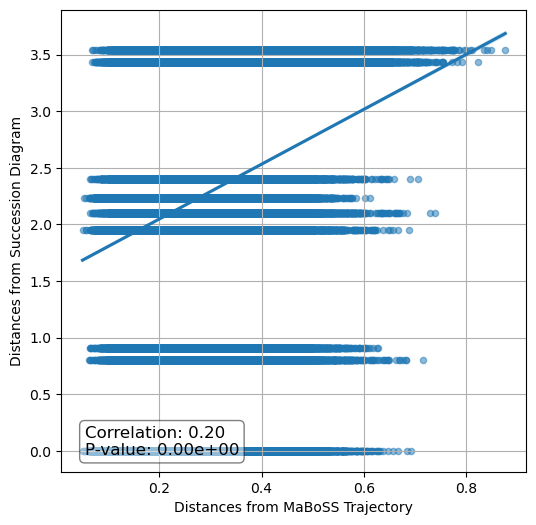

In [20]:
from scipy.stats import pearsonr

# Extract the upper triangular parts of the distance matrices (excluding the diagonal)
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape, dtype='bool'), k=1)).stack()

distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape, dtype='bool'), k=1)).stack()

# Compute the correlation and p-value
correlation, p_value = pearsonr(distances_1.values, distances_2.values)

# Print the correlation and p-value
print(f"Correlation between the two distance matrices: {correlation}")
print(f"P-value: {p_value}")

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(6, 6))
sns.regplot(x=distances_1.values, y=distances_2.values, scatter_kws={'s': 20, 'alpha': 0.5})
plt.xlabel("Distances from MaBoSS Trajectory")
plt.ylabel("Distances from Succession Diagram")
plt.grid(True)

# Add a box label with correlation and p-value
plt.text(
    0.05, 0.1, 
    f"Correlation: {correlation:.2f}\nP-value: {p_value:.2e}", 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top', 
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
)

#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_distCorr.pdf')

plt.show()

plt.close()

In [ ]:
model.succession_diagram.cluster_sdnet(n_cluster = 2)
model_list = list(model.succession_diagram.models_net.keys())
sd_cluster = model.succession_diagram.clusters
sd_cluster = pd.DataFrame(sd_cluster, columns = ['sd_cluster'], index = model_list)

SD networks clustered


/home/spankaew/Git/astrologics/astrologics/succession_diagram.py:203: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


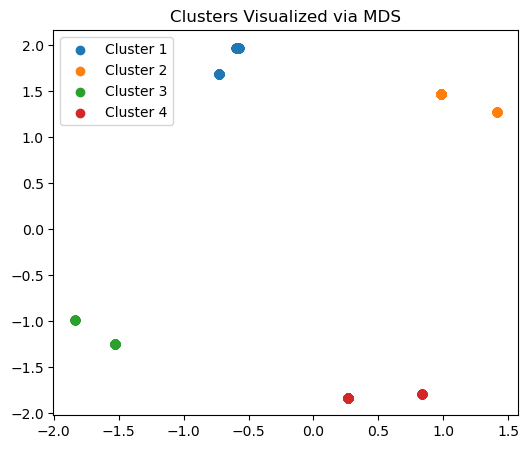

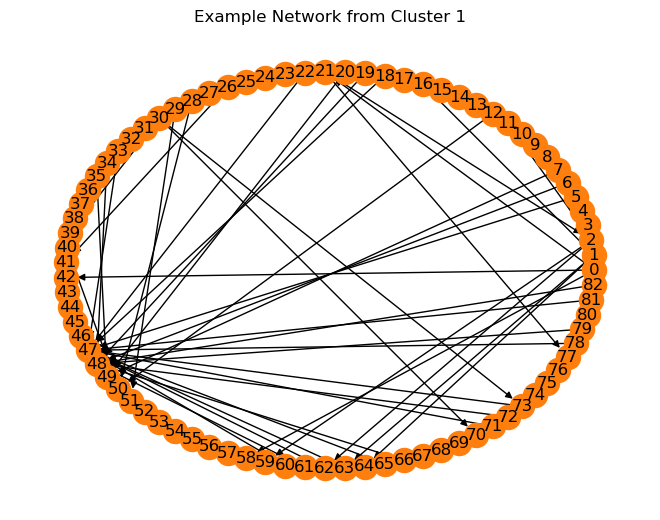

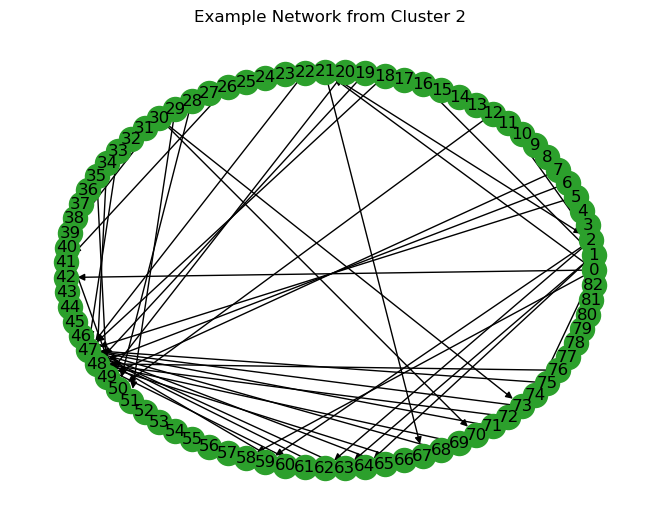

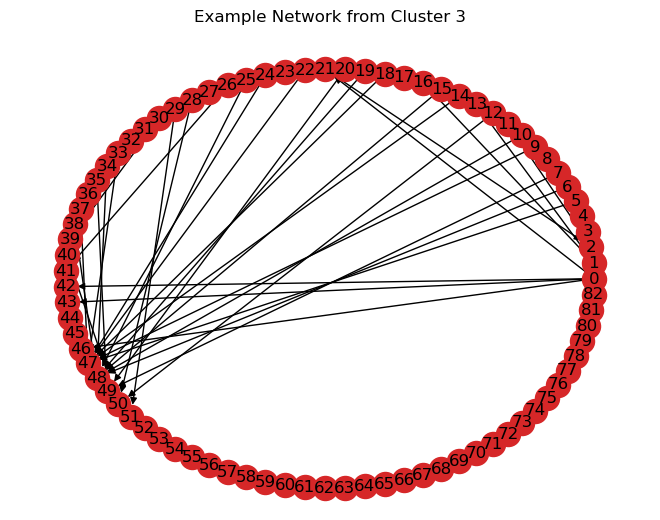

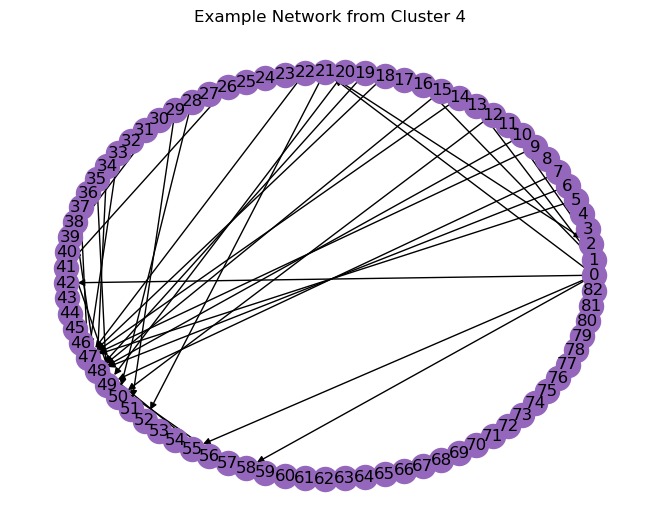

In [44]:
model.succession_diagram.plot_sdnet_cluster()

In [20]:
mds = MDS(dissimilarity='precomputed', random_state=1, n_init=20)
coords = mds.fit_transform(distance_matrix)
coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, sd_cluster],axis = 1)

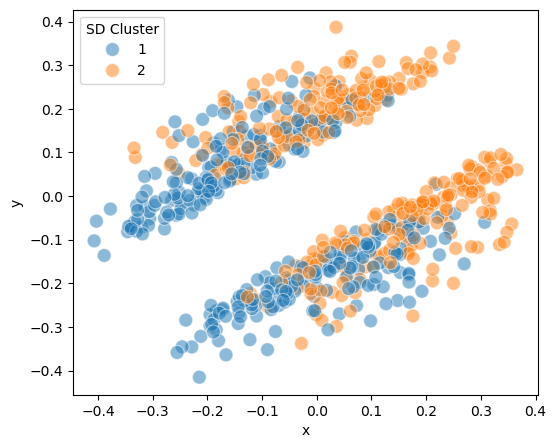

In [21]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='sd_cluster', palette='tab10', alpha=0.5, s=100)
plt.legend(title='SD Cluster')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/srd_trajMDS_clustbySD.pdf')

plt.show()
plt.close()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [15]:
model.create_logic()

Loading models logics


100%|██████████| 616/616 [00:00<00:00, 811.10it/s]


Concatenate results into matrix


100%|██████████| 616/616 [00:00<00:00, 1655.49it/s]

Logic object created


Flatten models logic clauses


100%|██████████| 616/616 [00:00<00:00, 1836312.20it/s]


Concatenate results into matrix


100%|██████████| 616/616 [00:00<00:00, 1676.57it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Flattend logic clause created


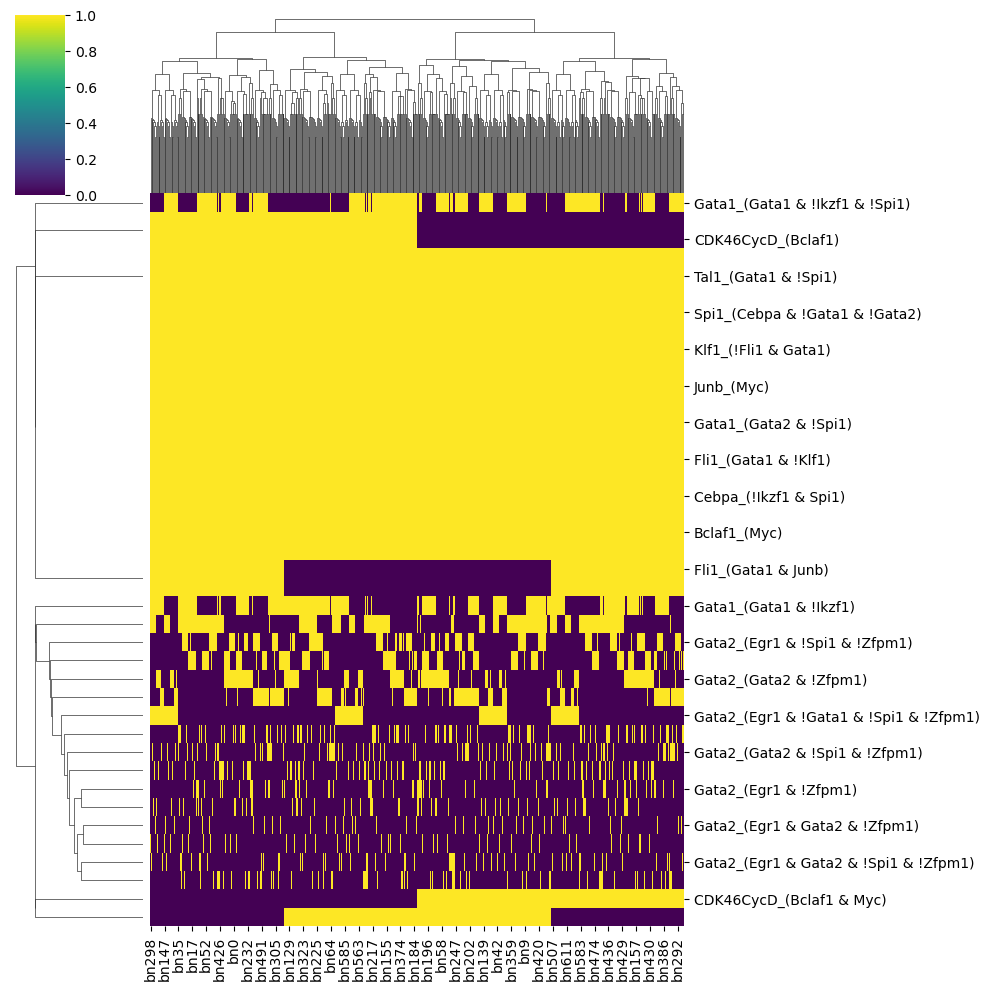

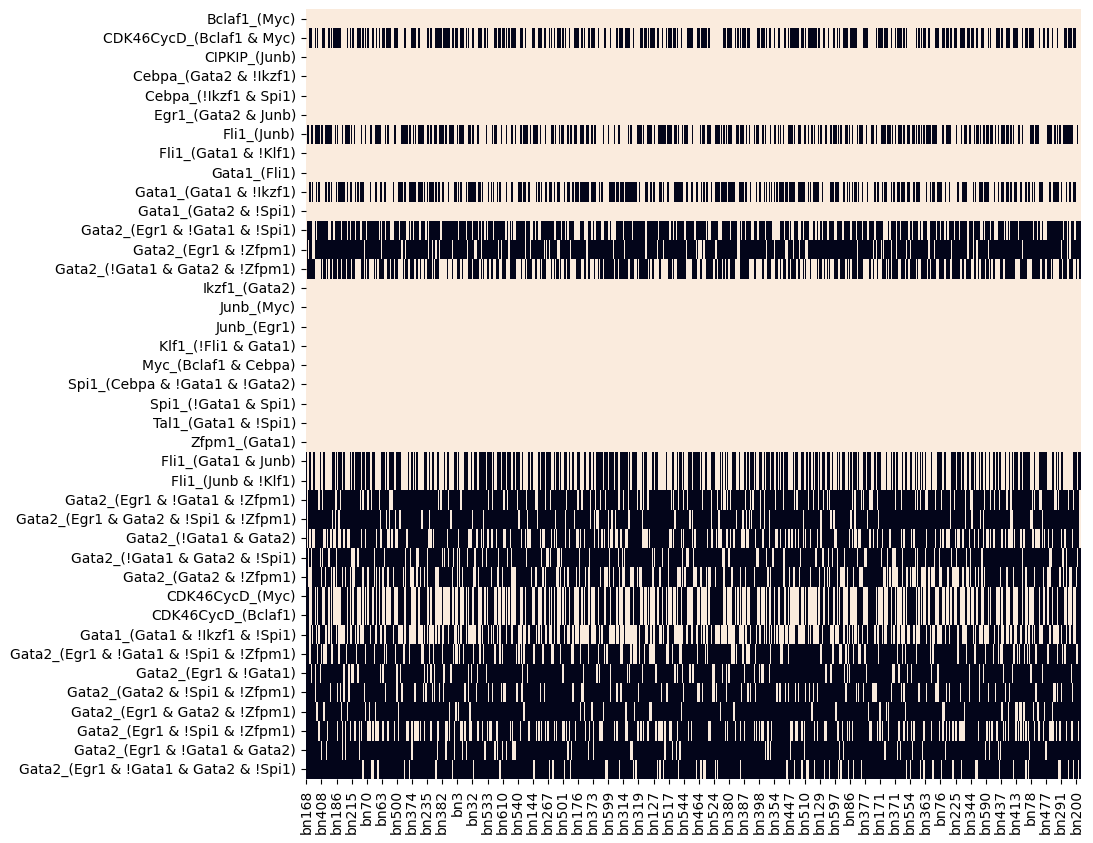

In [16]:
model.logic.create_flattend_logic_clause()
# Create the clustermap
clustermap = sns.clustermap(model.logic.logic_clause_flattend, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.logic.logic_clause_flattend.iloc[row_order, col_order]
# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(model.logic.logic_clause_flattend, vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_Logic.pdf')
plt.show()
plt.close()

In [37]:
model.logic.calculate_logic_pca()

PCA calculated


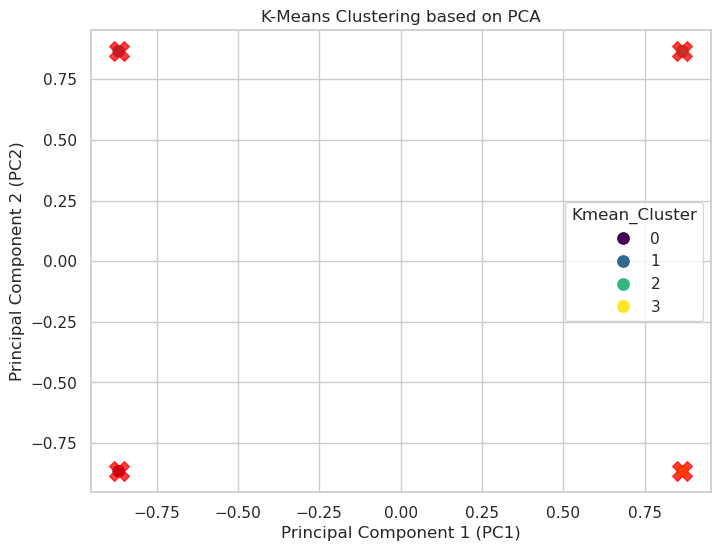

In [38]:
model.logic.calculate_kmean_cluster(num_cluster = 4)

In [17]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(model.trajectory.cluster_dict)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

/tmp/ipykernel_17820/2269529814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_17820/2269529814.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


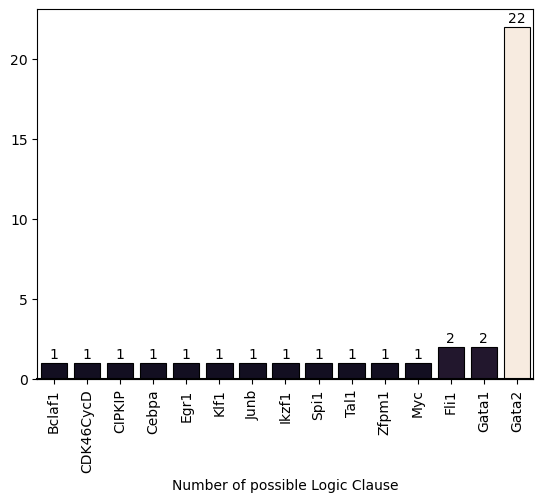

In [18]:
# Sort the dataframe by logic_length
sorted_var_logic_length = var_logic_length.sort_values(by='logic_length', ascending=True)

# Create a barplot with sorted values and color based on logic_length
sns.barplot(
    x=sorted_var_logic_length.index, 
    y=sorted_var_logic_length.logic_length, 
    edgecolor='black',
    linewidth=0.8,
    palette=sns.color_palette("rocket", as_cmap=True)(sorted_var_logic_length.logic_length / sorted_var_logic_length.logic_length.max())

)

# Add a horizontal line at y=0
plt.axhline(0, color="k", clip_on=False)
plt.ylabel(None)
plt.xlabel('Number of possible Logic Clause')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set labels and title
# Add numbers on top of the bars
for index, value in enumerate(sorted_var_logic_length.logic_length):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

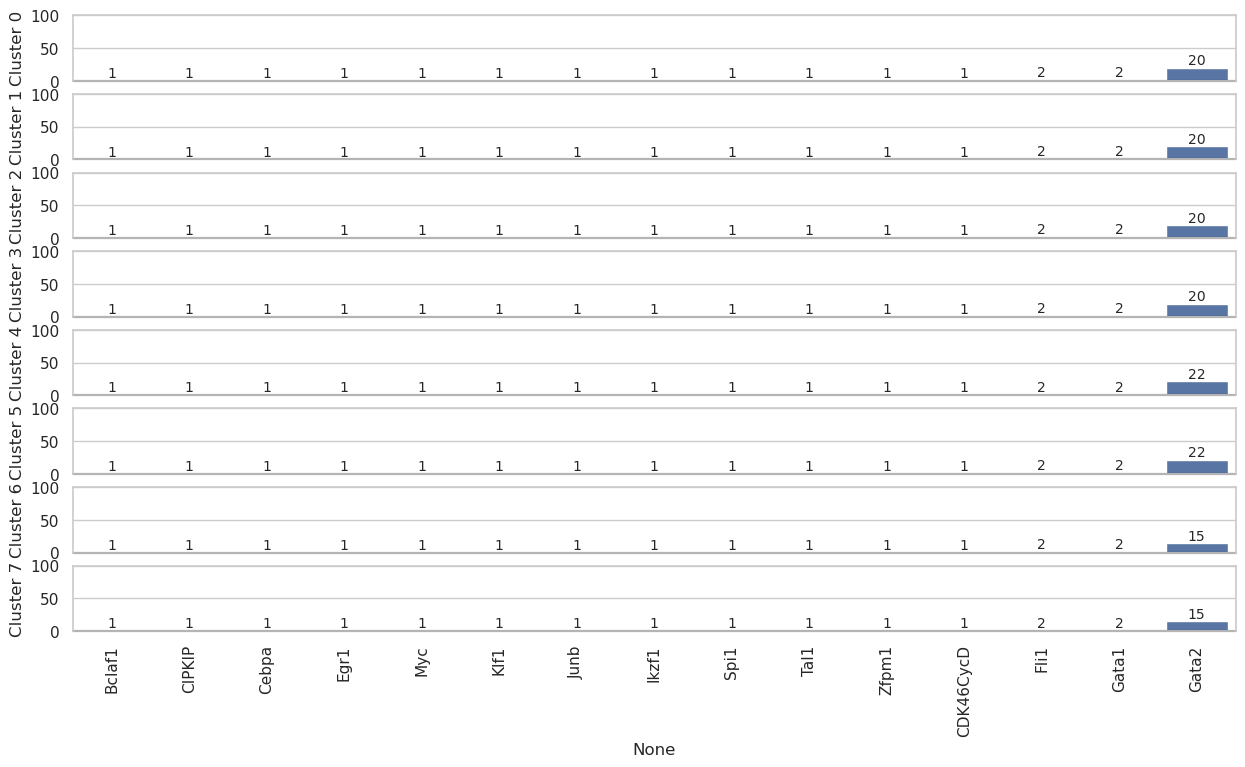

In [42]:
fig, axes = plt.subplots(8, 1, figsize=(15, 8), sharex=True)
plt.ylim(0, 65)

for i in range(8):
    sns.barplot(x=var_logic_clust.index, y=var_logic_clust[i], ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(f"Cluster {i}")
    axes[i].bar_label(axes[i].containers[0], fontsize=10)
    axes[i].set_ylim(0, 100)

plt.xticks(rotation=90)
plt.show()

In [19]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create a dictionary to store features and their groups
feature_groups = {
    'Feature': constant_features + varied_features + marker_features,
    'Group': (['Constant'] * len(constant_features)) +
             (['Varied'] * len(varied_features)) +
             (['Marker'] * len(marker_features))
}

# Convert the dictionary to a DataFrame
features_df = pd.DataFrame(feature_groups)

# Add the node features into the DataFrame
features_df['Node'] = features_df['Feature'].str.split('_', n=1, expand=True)[0]

/tmp/ipykernel_17820/4030930402.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_17820/4030930402.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


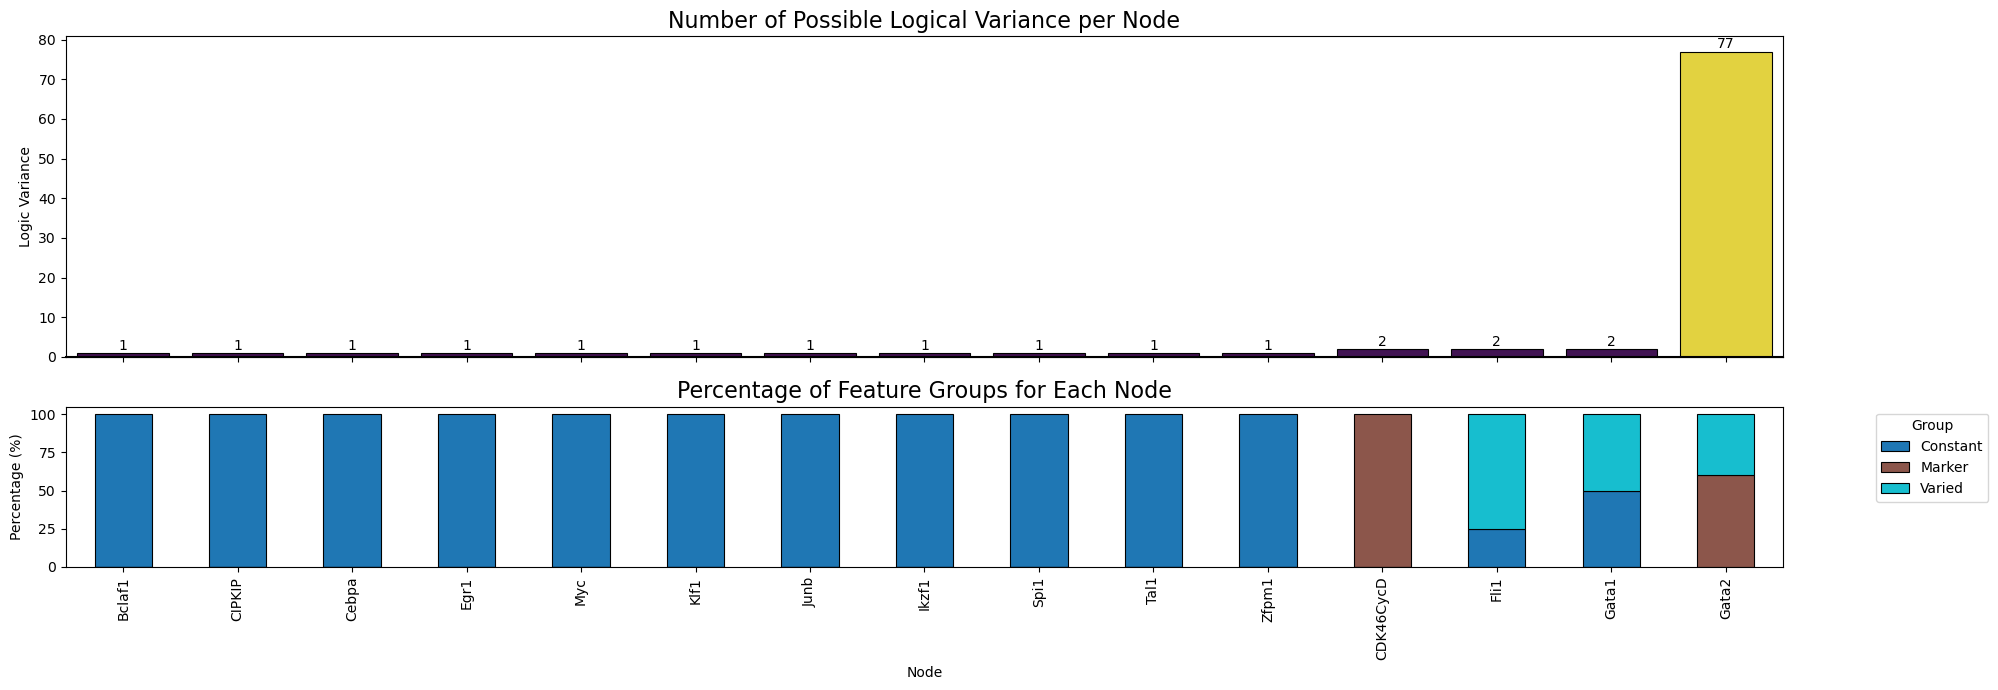

In [20]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0])

# Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Logic Variance')
axes[0].set_title('Number of Possible Logical Variance per Node', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_percentage = features_df_grouped.div(features_df_grouped.sum(axis=1), axis=0) * 100
features_df_percentage.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8)

# Customize the second plot
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Node')
axes[1].set_title('Percentage of Feature Groups for Each Node', fontsize=16)
axes[1].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


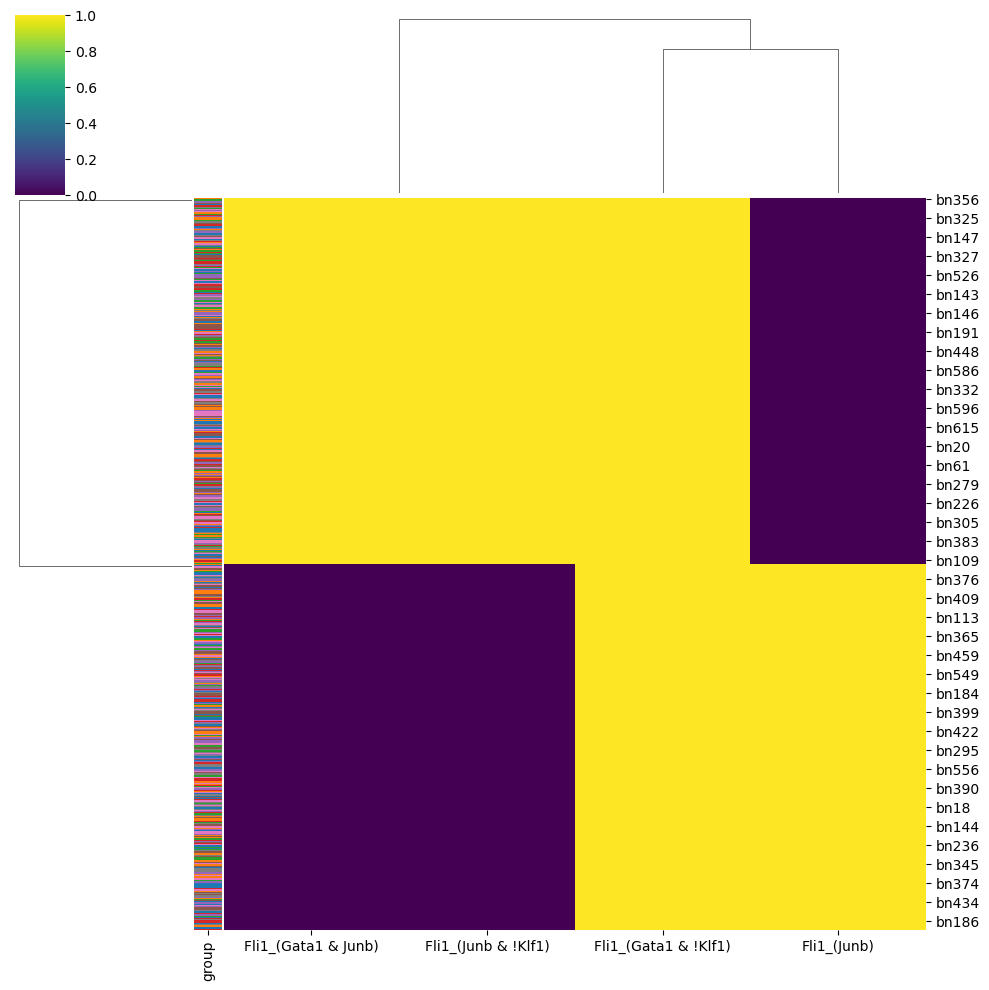

In [ ]:
selected_features = features_df.loc[features_df['Node'] == 'Fli1'].Feature

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[selected_features], cmap='viridis', figsize=(10, 10), row_colors=group_colors)

In [45]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean
result_df

,Cluster_6,Cluster_7,Cluster_5,Cluster_0,Cluster_1,Cluster_3,Cluster_2,Cluster_4
Bclaf1_(Myc),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
CDK46CycD_(Bclaf1 & Myc),0.000000,1.000000,0.000000,0.00,0.00,1.00,1.00,1.000000
CIPKIP_(Junb),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Cebpa_(Gata2 & !Ikzf1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Cebpa_(!Ikzf1 & Spi1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Egr1_(Gata2 & Junb),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Fli1_(Junb),0.500000,0.500000,0.500000,0.50,0.50,0.50,0.50,0.500000
Fli1_(Gata1 & !Klf1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Gata1_(Fli1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Gata1_(Gata1 & !Ikzf1),0.500000,0.500000,0.500000,0.50,0.50,0.50,0.50,0.500000


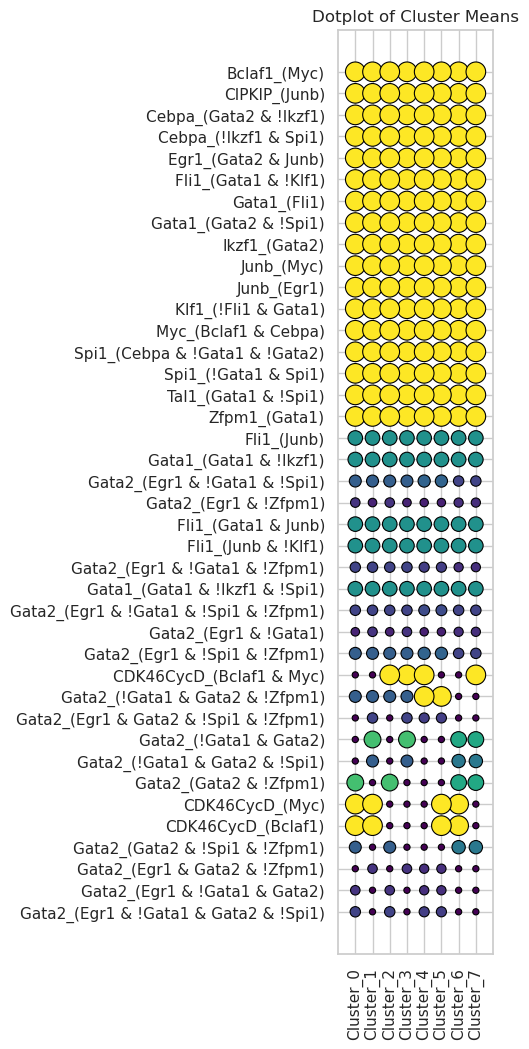

In [48]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean

# Convert the result_df to a long format for easier plotting with seaborn
result_df = result_df.loc[constant_features + varied_features + marker_features,:]
result_long_df = result_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')

# Create the dot plot
plt.figure(figsize=(2, 12))
sns.set_theme(style="whitegrid")
dotplot = sns.scatterplot(data=result_long_df, 
                          x=pd.Categorical(result_long_df['Cluster'], categories=['Cluster_0', 'Cluster_1',
                                                                                  'Cluster_2', 'Cluster_3',
                                                                                  'Cluster_4', 'Cluster_5',
                                                                                  'Cluster_6', 'Cluster_7',], ordered=True), 
                          y='index', 
                          size='Value', hue='Value', 
                          palette='viridis', sizes=(20, 200), legend=None,
                          edgecolor='black', linewidth=0.8)

# Customize the plot
plt.title('Dotplot of Cluster Means')
#plt.xlabel('Cluster')
plt.ylabel(None)
plt.xticks(rotation=90)
plt.xlim(-1,8)
#plt.savefig('/home/spankaew/Git/astrologics/figures/hh_traj_dotplot.pdf', bbox_inches='tight')

plt.show()
plt.close()

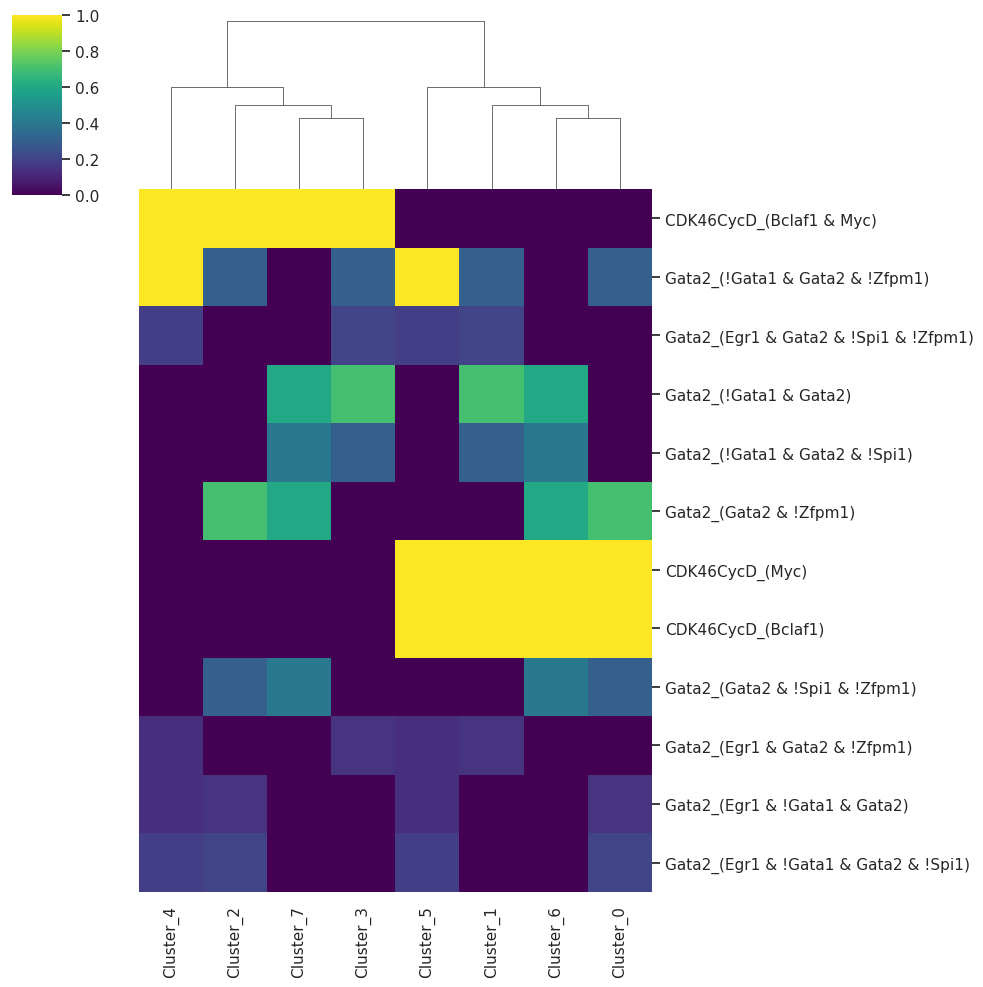

In [53]:
sns.clustermap(result_df.loc[marker_features,:], row_cluster = False, cmap = 'viridis')

,Myc,Bclaf1,CDK46CycD,Junb,CIPKIP,Gata2,Ikzf1,Spi1,Cebpa,Egr1,Gata1,Klf1,Fli1,Zfpm1,Tal1,model_id,timepoint
0,0.053219,0.649118,0.013121,0.013687,0.003299,0.788363,0.309920,0.003318,0.233178,0.002386,0.351502,0.016022,0.727098,0.419691,0.733596,bn168,0.0
1,0.105506,0.302545,0.062461,0.064207,0.026605,0.451381,0.485113,0.011929,0.235305,0.017447,0.695588,0.084703,0.614905,0.525894,0.641249,bn168,1.0
2,0.077976,0.166295,0.081489,0.085037,0.058931,0.239981,0.385374,0.013706,0.122727,0.027467,0.793545,0.128515,0.654996,0.675531,0.717412,bn168,2.0
3,0.044242,0.095907,0.067872,0.074973,0.073715,0.118203,0.243757,0.013567,0.054765,0.024672,0.819424,0.137699,0.687999,0.763139,0.774686,bn168,3.0
4,0.024735,0.051954,0.047688,0.056763,0.067285,0.056776,0.136621,0.012612,0.028389,0.017515,0.823879,0.132407,0.700562,0.800956,0.805826,bn168,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004200,0.004200,0.000000,0.890800,0.133600,0.757200,0.890800,0.890800,bn504,25.0
18476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004200,0.004200,0.000000,0.890800,0.133600,0.757200,0.890800,0.890800,bn504,26.0
18477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004200,0.004200,0.000000,0.890800,0.133600,0.757200,0.890800,0.890800,bn504,27.0
18478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004200,0.004200,0.000000,0.890800,0.133600,0.757200,0.890800,0.890800,bn504,28.0


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

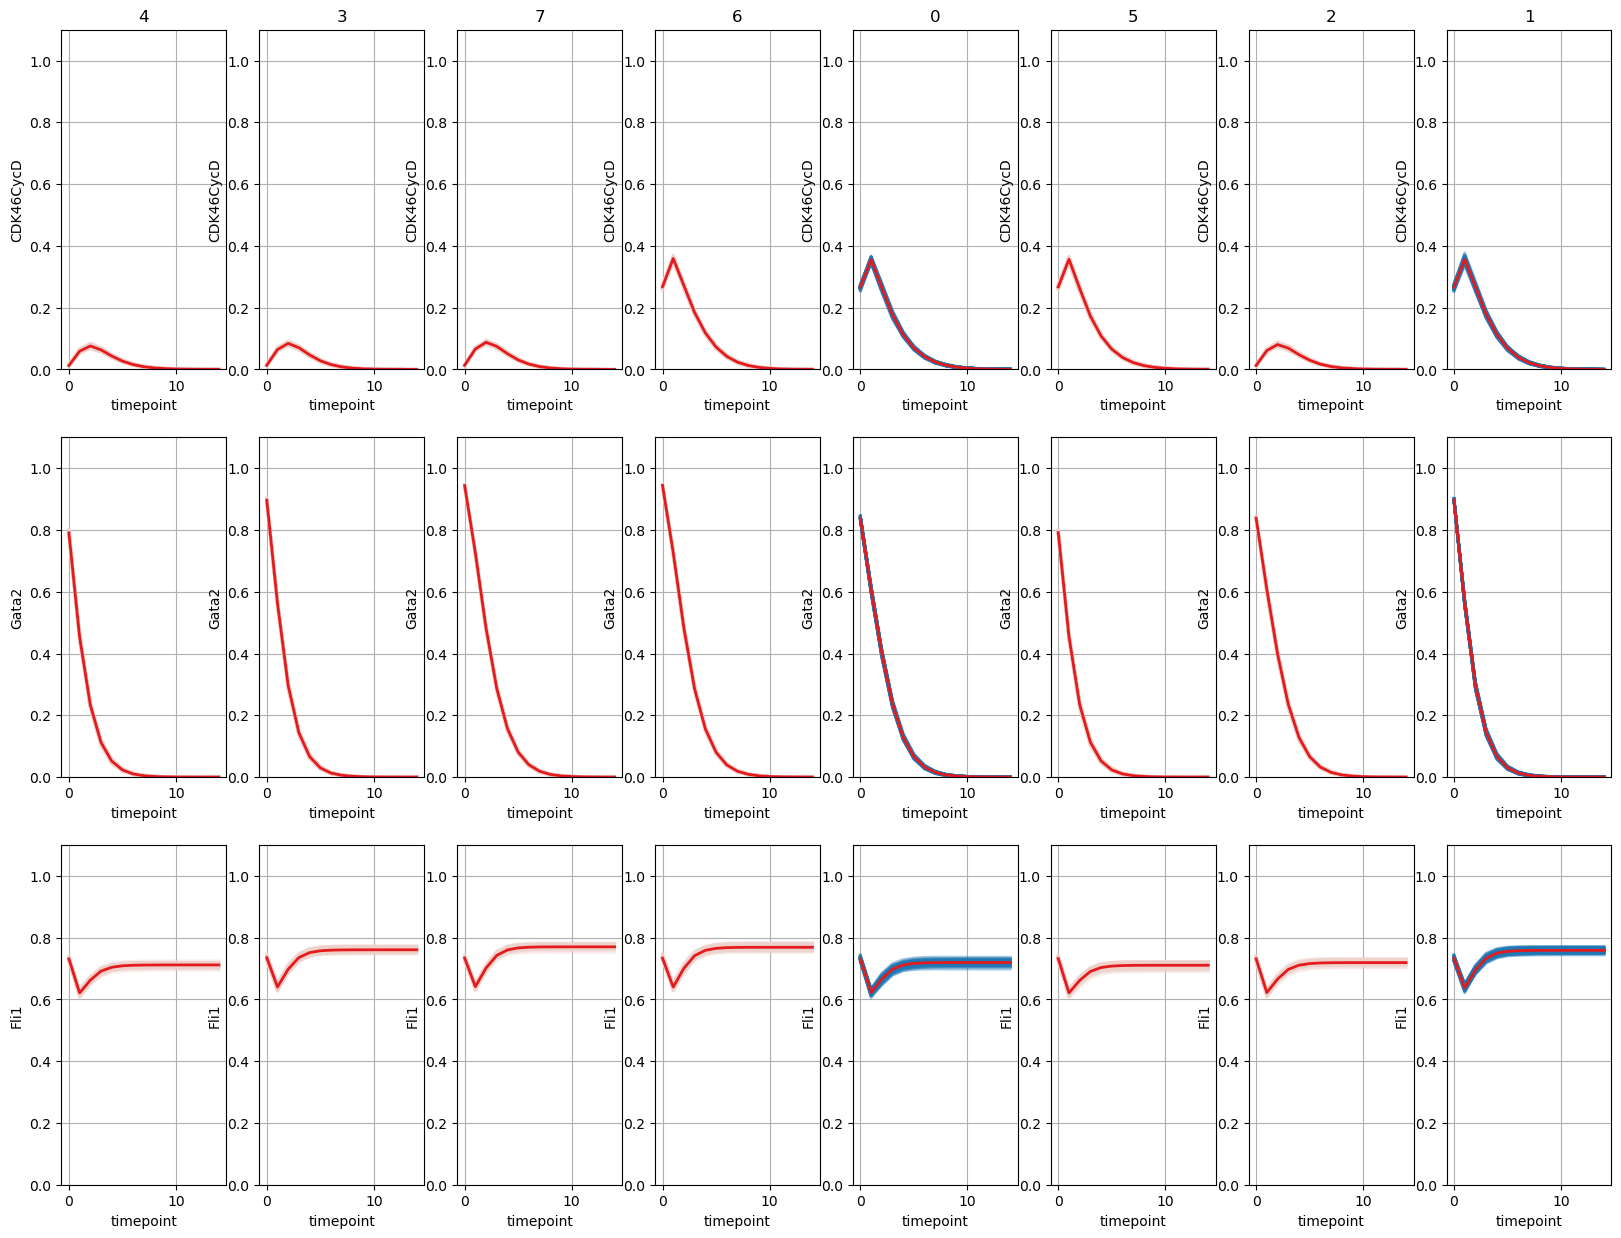

In [39]:
# Setup the gene list
selected_genes = ['CDK46CycD', 'Gata2','Fli1']
num_timesteps = 15
model_mtx['type'] = model_mtx['model_id'].map(model.trajectory.cluster_dict)
cluster_type = list(model_mtx.type.unique())

# Function to create matrix for each condition
def create_vis_matrix(cluster_type):
    vis = model_mtx.loc[model_mtx['type'] == cluster_type]
    vis = vis[selected_genes + ['timepoint', 'model_id']]
    vis = vis[vis.timepoint.isin(range(0, num_timesteps))]
    vis['cluster'] = cluster_type
    return vis

# Create matrices for each condition
vis_matrices = [create_vis_matrix(i) for i in cluster_type]

# Plot with Seaborn
plt.figure(figsize=(20, 15))
n_genes = len(selected_genes)

for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, 8, 8 * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, hue='cluster', units = 'model_id', estimator = None, alpha = 0.4)
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.grid(True)
        plot.legend().remove()
        if i == 0:
            plot.set_title(f'{cluster_type[j]}')

for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, 8, 8 * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, hue='cluster', palette='Set1')
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.grid(True)
        plot.legend().remove()
        if i == 0:
            plot.set_title(f'{cluster_type[j]}')

#plt.tight_layout()
plt.show()
plt.close()

In [18]:
import maboss
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
test = maboss.loadBNet(model_path + 'bn0.bnet')
test.mutate('Spi1','OFF')

{'Spi1': 'OFF'}